<a href="https://colab.research.google.com/github/maggieliuzzi/reinforcement_learning/blob/master/policy_gradient/DiscreteActions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approximating/ parameterising policy.

Output of policy model: probability distribution over the action space

- OpenAI Gym's Cartpole environment
- TensorFlow 1

In [3]:
from __future__ import print_function, division
from builtins import range
import gym
import os
import sys
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf  # TensorFlow 1
print(tf.__version__)
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

1.15.2


In [0]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [0]:
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
    self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))  # tf.random_normal( for tf < 2
    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))
    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a)

In [0]:
# approximates pi(a | s)
class PolicyModel:
  def __init__(self, D, K, hidden_layer_sizes):
    # create the graph
    # K = number of actions
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    # layer = HiddenLayer(M1, K, lambda x: x, use_bias=False)
    layer = HiddenLayer(M1, K, tf.nn.softmax, use_bias=False)
    self.layers.append(layer)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')
    self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    p_a_given_s = Z
    # action_scores = Z
    # p_a_given_s = tf.nn.softmax(action_scores)
    # self.action_scores = action_scores
    self.predict_op = p_a_given_s

    # self.one_hot_actions = tf.one_hot(self.actions, K)

    selected_probs = tf.log(
      tf.reduce_sum(
        p_a_given_s * tf.one_hot(self.actions, K),
        reduction_indices=[1]
      )
    )

    # self.selected_probs = selected_probs
    cost = -tf.reduce_sum(self.advantages * selected_probs)
    # self.cost = cost
    # self.train_op = tf.train.AdamOptimizer(1e-1).minimize(cost)
    self.train_op = tf.train.AdagradOptimizer(1e-1).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-4, momentum=0.9).minimize(cost)
    # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, actions, advantages):
    X = np.atleast_2d(X)
    actions = np.atleast_1d(actions)
    advantages = np.atleast_1d(advantages)
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: X,
        self.actions: actions,
        self.advantages: advantages,
      }
    )

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def sample_action(self, X):
    p = self.predict(X)[0]
    return np.random.choice(len(p), p=p)

In [0]:
# approximates V(s)
class ValueModel:
  def __init__(self, D, hidden_layer_sizes):
    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    layer = HiddenLayer(M1, 1, lambda x: x)
    self.layers.append(layer)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = tf.reshape(Z, [-1]) # the output
    self.predict_op = Y_hat

    cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
    # self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-2, momentum=0.9).minimize(cost)
    self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, Y):
    X = np.atleast_2d(X)
    Y = np.atleast_1d(Y)
    self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

In [0]:
def play_one_td(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    # if done:
    #   reward = -200

    # update the models
    V_next = vmodel.predict(observation)[0]
    G = reward + gamma*V_next
    advantage = G - vmodel.predict(prev_observation)
    pmodel.partial_fit(prev_observation, action, advantage)
    vmodel.partial_fit(prev_observation, G)

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward

In [0]:
def play_one_mc(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  states = []
  actions = []
  rewards = []

  reward = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)

    states.append(observation)
    actions.append(action)
    rewards.append(reward)

    prev_observation = observation
    observation, reward, done, info = env.step(action)

    if done:
      reward = -200

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  # save the final (s,a,r) tuple
  action = pmodel.sample_action(observation)
  states.append(observation)
  actions.append(action)
  rewards.append(reward)

  returns = []
  advantages = []
  G = 0
  for s, r in zip(reversed(states), reversed(rewards)):
    returns.append(G)
    advantages.append(G - vmodel.predict(s)[0])
    G = r + gamma*G
  returns.reverse()
  advantages.reverse()

  # update the models
  pmodel.partial_fit(states, actions, advantages)
  vmodel.partial_fit(states, returns)

  return totalreward

In [0]:
D = env.observation_space.shape[0]
K = env.action_space.n
pmodel = PolicyModel(D, K, [])
vmodel = ValueModel(D, [10])

In [22]:
env = gym.make('CartPole-v0')
# env.render()

init = tf.global_variables_initializer()
session = tf.InteractiveSession()
session.run(init)
pmodel.set_session(session)
vmodel.set_session(session)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
gamma = 0.99
N = 1000
totalrewards = np.empty(N)
costs = np.empty(N)

In [15]:
for n in range(N):
  totalreward = play_one_mc(env, pmodel, vmodel, gamma)
  totalrewards[n] = totalreward
  if n % 100 == 0:
    print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

episode: 0 total reward: 21.0 avg reward (last 100): 21.0
episode: 100 total reward: 33.0 avg reward (last 100): 68.82178217821782
episode: 200 total reward: 111.0 avg reward (last 100): 160.04950495049505
episode: 300 total reward: 199.0 avg reward (last 100): 182.9009900990099
episode: 400 total reward: 163.0 avg reward (last 100): 184.84158415841586
episode: 500 total reward: 199.0 avg reward (last 100): 187.23762376237624
episode: 600 total reward: 199.0 avg reward (last 100): 190.11881188118812
episode: 700 total reward: 199.0 avg reward (last 100): 193.77227722772278
episode: 800 total reward: 199.0 avg reward (last 100): 192.94059405940595
episode: 900 total reward: 199.0 avg reward (last 100): 190.92079207920793


In [16]:
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

avg reward for last 100 episodes: 195.21
total steps: 174732.0


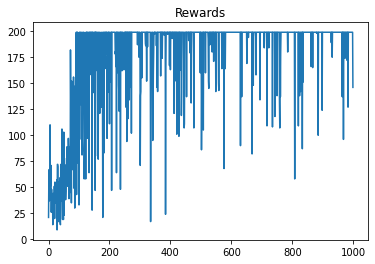

In [17]:
plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

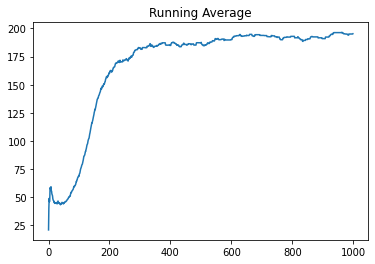

In [18]:
plot_running_avg(totalrewards)